In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import statistics
import pandas as pd
import tensorflow as tf
from IPython.display import Image
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST as mnist
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable



#simulationRun, sample, restOfMeasurements
input_size = 1*56
output_size = 1

In [3]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        #self.linear1 = nn.Linear(input_size, 256)
        #self.linear2 = nn.Linear(256, 128)
        #self.linear3 = nn.Linear(128, output_size)
        self.conv1 = nn.Conv2d(3,9,3,padding=1)
        self.conv2 = nn.Conv2d(9,9,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(9,18,3,padding=1)
        self.conv4 = nn.Conv2d(18,18,3,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv5 = nn.Conv2d(18,36,3,padding=1)
        self.conv6 = nn.Conv2d(36,36,3,padding=1)
        self.pool3 = nn.MaxPool2d(2,2)

        self.linear1 = nn.Linear(576,100)
        self.dropout1 = nn.Dropout2d(.5)
        self.linear2 = nn.Linear(100,10)

    def forward(self, xb):
        # Flatten images into vectors
        #out = xb.view(xb.size(0), -1)
        out = xb
        #print(out.shape)
        # Apply layers & activation function

        # part 1
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = self.pool1(out)
        #print(out.shape)

        # part 2
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.pool2(out)
        #print(out.shape)

        # part 3
        out = F.relu(self.conv5(out))
        out = F.relu(self.conv6(out))
        out = self.pool3(out)
        #print(out.shape)

        # part 4
        out = F.relu(self.linear1(torch.flatten(out,start_dim=1)))
        out = F.relu(self.dropout1(out))
        out = self.linear2(out)
        return out

NameError: name 'ImageClassificationBase' is not defined

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(1, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        self.out = nn.Linear(hidden_size, 1)

    def step(self, input, hidden=None):
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = inputs[i]
            else:
                input = output
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden

In [12]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
            #add pnf here for OmniAnomaly
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [13]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.forward(batch) for batch in val_loader]
    return outputs

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    plt.show()

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show()

In [14]:
train = pd.read_csv('C:\\Users\\Charlie\\Desktop\\TEP_Data\\TEP_Faulty_Training.csv')
#x = train.drop(columns=['faultNumber'])
test = pd.read_csv('C:\\Users\\Charlie\\Desktop\\TEP_Data\\TEP_Faulty_Testing.csv')
#d = pd.read_csv('C:\\Users\\Charlie\\Desktop\\NGAFID-REFERENCE\\NGAFID_Anomaly_Detection\\NGAFID_dataset\\c172_file_2.csv')
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, test, 
                                                    train_size=0.67, 
                                                    random_state=42)

MemoryError: Unable to allocate 128. KiB for an array with shape (16384,) and data type int64

In [12]:
print(X_test)

         Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
3577888     3577889           16            358     389  0.19550   3706.6   
4993932     4993933            8            500     433  0.32124   3632.8   
4094900     4094901           10            410     401  0.28359   3676.0   
4420497     4420498            1            443     498  0.75021   3577.9   
634465       634466            9             64     466  0.28790   3625.6   
...             ...          ...            ...     ...      ...      ...   
4720741     4720742            2            473     242  0.27336   3698.9   
440750       440751            2             45     251  0.28579   3675.8   
2926881     2926882           14            293     382  0.28478   3741.6   
648868       648869           18             65     369  0.20984   3616.6   
1101314     1101315            3            111     315  0.21058   3673.7   

         xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \

In [ ]:
#train_df = pd.DataFrame(train)
#test_df = pd.DataFrame(test)
train_df = X_train
test_df = X_test

In [11]:
def get_input_fn(data_set, num_epochs = None, shuffle=True):
    return tf.estimator.inputs.pandas_input_fn(
        x = data_set.drop(['faultNumber', 'simulationRun', 'sample'], axis=1),
        y = data_set['faultNumber'],
        num_epochs = num_epochs,
        shuffle = shuffle)

def get_feature_cols(data_set):
    return [tf.feature_column.numeric_cloumn(k)
           for k in data_set.drop(['faultNumber', 'simulationRun', 'sample'], axis=1).keys()]

In [23]:
regressor = tf.estimator.DNNRegressor(feature_columns=get_feature_cols(train_df), hidden_units=[10, 10])

regressor.train(get_input_fn(train_df, 10), steps=500)

AttributeError: module 'tensorflow._api.v2.feature_column' has no attribute 'numeric_cloumn'

In [18]:
dtype = torch.float
device = get_default_device()

#torch.manual_seed(43)
val_size = 5000
train_size = len(train_df) - val_size
batch_size = 128

    

train_ds, val_ds = random_split(train_df, [train_size, val_size])
len(train_ds), len(val_ds)

train_loader = DataLoader(X_train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(test.faultNumber, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(X_test, batch_size*2, num_workers=4, pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

print(test_loader.__len__())

rnnModel = SimpleRNN(14)
model = to_device(rnnModel, device)

print(count_parameters(model))
print(model)
history = [evaluate(model, val_loader)]
print(history)

history += fit(20, 1e-1, model, train_loader, val_loader)

history += fit(5, 1e-2, model, train_loader, val_loader)

history += fit(5, 1e-3, model, train_loader, val_loader)

history += fit(4, 1e-4, model, train_loader, val_loader)

plot_losses(history)

plot_accuracies(history)

print(evaluate(model, test_loader))

"""
y = regressor.predict(input_fn = get_input_fn(test_df[:10], num_epochs=1, shuffle=False))
predictions = list(p["predictions"] for p in itertools.islice(y, 6))

print("Prediction:" + str([int(i[0]) for i in predictions]))
print("Actual:" + str(test_df['faultNumber'][:10].values))
"""

6446
3403
SimpleRNN(
  (inp): Linear(in_features=1, out_features=14, bias=True)
  (rnn): LSTM(14, 14, num_layers=2, dropout=0.05)
  (out): Linear(in_features=14, out_features=1, bias=True)
)


RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'mat1' in call to _th_addmm

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,2,1,1,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,3,1,1,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,4,1,1,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,5,1,1,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


Index(['Unnamed: 0', 'faultNumber', 'simulationRun', 'sample', 'xmeas_1',
       'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7',
       'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13',
       'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19',
       'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
       'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31',
       'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37',
       'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2',
       'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10',
       'xmv_11'],
      dtype='object')


(5000000, 56)


In [14]:
def flatten(x):
    return to_var(x.view(x.size(0), -1))

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [15]:
bs = 128
dataset = mnist(root='./data', train=True, transform=ToTensor(), download=False)
print(type(dataset))
 
data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

<class 'torchvision.datasets.mnist.MNIST'>


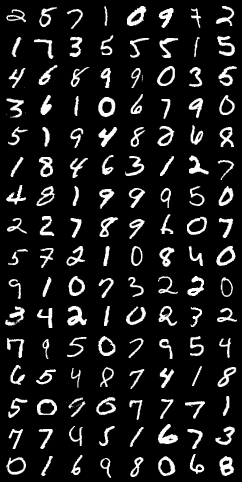

In [16]:
# Fixed input for debugging
fixed_x, _ = next(iter(data_loader))
save_image(fixed_x)
fixed_x = flatten(fixed_x)

Image('real_image.png')



In [17]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [18]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [19]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [44]:
epochs = 10

for epoch in range(epochs):
    for idx, (images, _) in enumerate(data_loader):
        images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/bs))
            recon_x, _, _ = vae(fixed_x)
            #save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'reconstructed/recon_image_{epoch}_{idx}.png')

Epoch[1/10] Loss: 549.112
Epoch[1/10] Loss: 173.645
Epoch[1/10] Loss: 146.516
Epoch[1/10] Loss: 136.295
Epoch[1/10] Loss: 130.410
Epoch[2/10] Loss: 126.730
Epoch[2/10] Loss: 119.696
Epoch[2/10] Loss: 120.784
Epoch[2/10] Loss: 117.433
Epoch[2/10] Loss: 117.306
Epoch[3/10] Loss: 116.539
Epoch[3/10] Loss: 117.384
Epoch[3/10] Loss: 113.607
Epoch[3/10] Loss: 111.044
Epoch[3/10] Loss: 114.646
Epoch[4/10] Loss: 110.698
Epoch[4/10] Loss: 110.967
Epoch[4/10] Loss: 109.481
Epoch[4/10] Loss: 112.709
Epoch[4/10] Loss: 109.935
Epoch[5/10] Loss: 110.541
Epoch[5/10] Loss: 109.469
Epoch[5/10] Loss: 107.741
Epoch[5/10] Loss: 110.580
Epoch[5/10] Loss: 105.741
Epoch[6/10] Loss: 107.993
Epoch[6/10] Loss: 105.517
Epoch[6/10] Loss: 111.742
Epoch[6/10] Loss: 112.952
Epoch[6/10] Loss: 107.651
Epoch[7/10] Loss: 106.690
Epoch[7/10] Loss: 104.388
Epoch[7/10] Loss: 108.053
Epoch[7/10] Loss: 109.425
Epoch[7/10] Loss: 107.347
Epoch[8/10] Loss: 111.283
Epoch[8/10] Loss: 105.261
Epoch[8/10] Loss: 104.269
Epoch[8/10] 